<a href="https://colab.research.google.com/github/KenObata/TISMIR_notebooks/blob/main/text_statistics_en_10genre_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook is to investigate text statistics of lyrics in each genre

Situation: English only (=multi-class) genre detection using SMOTE.
Split: StratifiedKfold.


### Preprocess: import files

In [ ]:
#Check RAM size. If small, you can upgrade.
#you can enable a high-RAM runtime via Runtime > Change runtime type in the menu
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 3.3 MB/s 


In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from collections import Counter

from skmultilearn.model_selection import IterativeStratification   
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import csr_matrix
plt.style.use('seaborn')

CSV_FOLDER = 'drive/MyDrive/music4all/'
LANG_DIR = 'drive/MyDrive/music4all/split-language_only-artist_grouped'
SPLIT_DIR = 'drive/MyDrive/music4all/split-all_labels'
FIG_DIR = 'drive/MyDrive/music4all/figures'

font = {'size': 22}

matplotlib.rc('font', **font)

scikit-multilearn has to be installed from pip
https://github.com/scikit-multilearn/scikit-multilearn/issues/142

In [ ]:
def write_txt(path, list_of_str):
    with open(path, 'w') as f:
        for value in list_of_str:
            f.write(value)
            f.write('\n')

In [ ]:
def analyze_genre_tag_df(df, top_n=100):
    """plot the occurrences of top_n items in the given df"""
    def get_counter(items: list):
        """items: list of list"""    
        items = [g.split(',') for g in items]
        items = [item for sublist in items for item in sublist]
        items = Counter(items)    
        return items
    
    def plot_freqs(counter: Counter, top_n, title=''):
        most_common = counter.most_common(top_n)
        names, counts = list(zip(*most_common))

        xs = np.arange(len(names))
        plt.figure(figsize=(18, 7))
        plt.bar(xs, counts)
        plt.xticks(xs + 0.2, names, rotation=60, size=17, ha='right') 
        plt.title('Top-%d %s (out of %d in total)' % (top_n, title, len(counter)), size=20)
        plt.ylabel('occurrence', size=17)
        
    column_name = df.columns[1]
    labels = df[column_name].tolist()
    labels = get_counter(labels)
    
    print('Number of %s: %d' % (column_name, len(labels)))

    plot_freqs(labels, top_n=top_n, title=column_name)
    return labels
    
def analyze_genre_tag_csv(csv_path, top_n):
    """wrapper of analyze_genre_tag_df"""
    basename = os.path.basename(csv_path)
    df = pd.read_csv(os.path.join(CSV_FOLDER, csv_path), header=0, sep='	')
    df.head()
    return analyze_genre_tag_df(df, top_n=top_n)

### Data preparation

id_genres.csv

Number of genres: 853


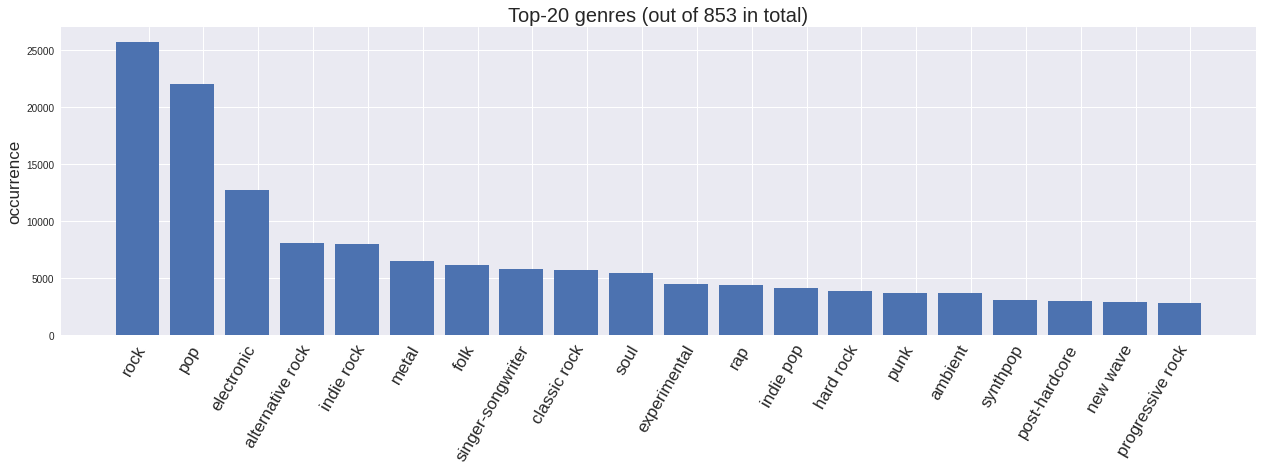

In [ ]:
genre_counter = analyze_genre_tag_csv('id_genres.csv', top_n=20)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'occurrence-genre.png'))

In [ ]:
genre_counter = sorted(genre_counter.items(), key=lambda item: item[1], reverse = True)
genre_counter_top = genre_counter[:15]

In [ ]:
genre_counter_top_list = [genre for genre, count in genre_counter_top ]
genre_counter_top_list

['rock',
 'pop',
 'electronic',
 'alternative rock',
 'indie rock',
 'metal',
 'folk',
 'singer-songwriter',
 'classic rock',
 'soul',
 'experimental',
 'rap',
 'indie pop',
 'hard rock',
 'punk']

In [ ]:
#filter genre dataset as top15 genre only and later inner join with English.
df_genres = pd.read_csv(os.path.join(CSV_FOLDER, 'id_genres.csv'), header=0, sep='	')
df_genre_top20 = df_genres[df_genres['genres'].isin(genre_counter_top_list)]
df_genre_top20

,id,genres
0,0009fFIM1eYThaPg,pop
11,00P2bHdWFkghmDqz,soul
14,00XWljDxNBgBKEEA,pop
16,00b6fV3nx5z2b8Ls,pop
26,013QDoTqbexEwkHr,pop
...,...,...
109253,zzgS4ZqyswamEWNj,pop
109254,zziALZG1JQ2uUjcy,metal
109262,zzx8CWdM7qkxKQpC,indie rock
109265,zzz0n04uuTUA7fNh,pop


Dataframe narrowed down to 18603 rows. Notice that rank20 has only 169 data. So depending on the result we might need to narrow down to top10 genre?

### Filter only English
 Note that this split have overlapping artist in both sets. See artist-grouped-stratified-split for an improved version.

In [ ]:
en_lang =['en']
df_lang = pd.read_csv(os.path.join(CSV_FOLDER, 'id_lang.csv'), header=0, sep='	')
df_lang_en=df_lang[ df_lang['lang'].isin(en_lang) ]
df_lang_en

,id,lang
0,0009fFIM1eYThaPg,en
1,0010xmHR6UICBOYT,en
2,002Jyd0vN4HyCpqL,en
3,006TYKNjNxWjfKjy,en
4,007LIJOPQ4Sb98qV,en
...,...,...
109264,zzyyPUs7hC9Nz2e1,en
109265,zzz0n04uuTUA7fNh,en
109266,zzzj3LYaZtYtbzSr,en
109267,zzznMjZAKnJJXQSj,en


Originally it was 109269 rows, and now there are 84103 rows.

### Now, combine split by language and genre, so we classify each genre by language.

In [ ]:
# merge three dataframes into one
df_genre_by_lang = pd.concat([df_genre_top20['id'], df_genre_top20['genres'], df_lang_en['lang']]
                             , join='inner' ,axis=1)

#Do inner join
df_genre_by_lang


,id,genres,lang
0,0009fFIM1eYThaPg,pop,en
11,00P2bHdWFkghmDqz,soul,en
16,00b6fV3nx5z2b8Ls,pop,en
26,013QDoTqbexEwkHr,pop,en
30,01EKNot8qVgZpKM7,rock,en
...,...,...,...
109253,zzgS4ZqyswamEWNj,pop,en
109254,zziALZG1JQ2uUjcy,metal,en
109262,zzx8CWdM7qkxKQpC,indie rock,en
109265,zzz0n04uuTUA7fNh,pop,en


Number of genres: 15


Counter({'alternative rock': 338,
         'classic rock': 167,
         'electronic': 953,
         'experimental': 180,
         'folk': 863,
         'hard rock': 195,
         'indie pop': 672,
         'indie rock': 1081,
         'metal': 157,
         'pop': 5179,
         'punk': 382,
         'rap': 978,
         'rock': 1449,
         'singer-songwriter': 695,
         'soul': 1288})

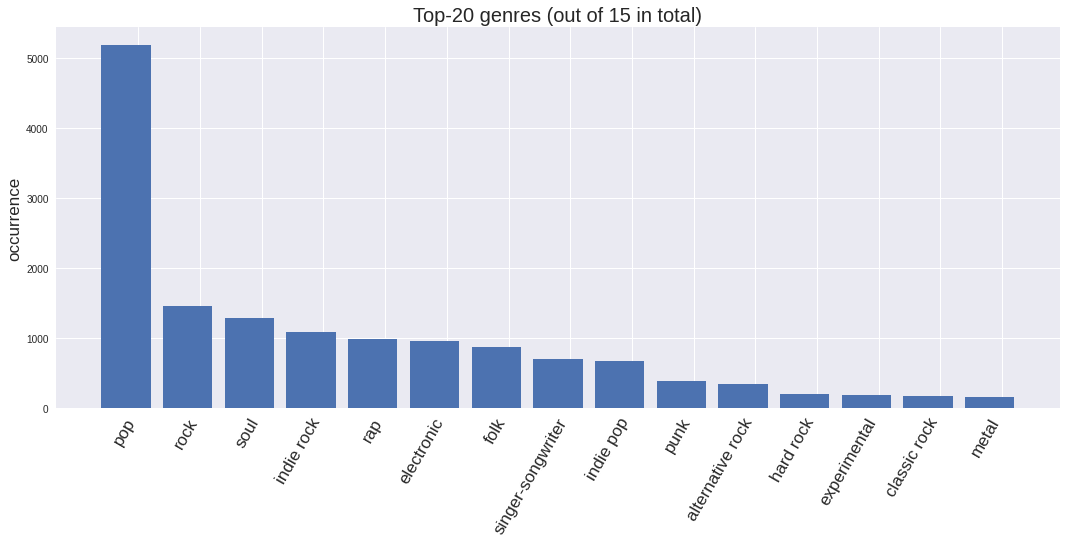

In [ ]:
analyze_genre_tag_df(df_genre_by_lang,20)

In [ ]:
final_genre_list = ["pop", "rock", "soul", "indie rock", "rap", "electronic", "folk", "singer-songwriter", "indie pop", "punk"]
#df_lang_en=df_lang[ df_lang['lang'].isin(en_lang) ]
df_genre_by_lang = df_genre_by_lang[ df_genre_by_lang["genres"].isin(final_genre_list) ]

After inner join, we can drop the bottom 5, alternative rock, hard rock, experimental, classic rock, and metal

Number of genres: 10


Counter({'electronic': 953,
         'folk': 863,
         'indie pop': 672,
         'indie rock': 1081,
         'pop': 5179,
         'punk': 382,
         'rap': 978,
         'rock': 1449,
         'singer-songwriter': 695,
         'soul': 1288})

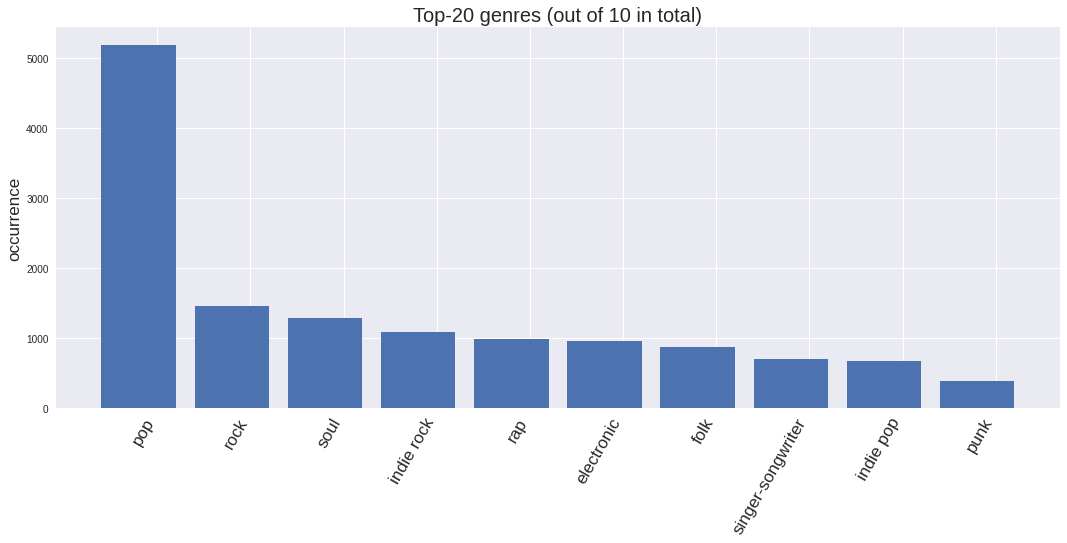

In [ ]:
analyze_genre_tag_df(df_genre_by_lang,20)

Reindex

In [ ]:
df_genre_by_lang = df_genre_by_lang.reset_index(drop=True)
df_genre_by_lang

,id,genres,lang
0,0009fFIM1eYThaPg,pop,en
1,00P2bHdWFkghmDqz,soul,en
2,00b6fV3nx5z2b8Ls,pop,en
3,013QDoTqbexEwkHr,pop,en
4,01EKNot8qVgZpKM7,rock,en
...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en
13536,zzgS4ZqyswamEWNj,pop,en
13537,zzx8CWdM7qkxKQpC,indie rock,en
13538,zzz0n04uuTUA7fNh,pop,en


### Get lyrics document as dataframe and append to X_train, X_test

In [ ]:
#create lyric column
df_genre_by_lang["lyric"] = ""
df_genre_by_lang

,id,genres,lang,lyric
0,0009fFIM1eYThaPg,pop,en,
1,00P2bHdWFkghmDqz,soul,en,
2,00b6fV3nx5z2b8Ls,pop,en,
3,013QDoTqbexEwkHr,pop,en,
4,01EKNot8qVgZpKM7,rock,en,
...,...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en,
13536,zzgS4ZqyswamEWNj,pop,en,
13537,zzx8CWdM7qkxKQpC,indie rock,en,
13538,zzz0n04uuTUA7fNh,pop,en,


In [ ]:
#create temporary lyric folder on google collab
# do not read texts from google drive. it is slow.
ZIP_FILE ="drive/MyDrive/music4all/lyrics.zip"

!unzip drive/MyDrive/music4all/lyrics.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/__MACOSX/lyrics/._zdBYCzbDNIMuhViX.txt  
  inflating: /content/lyrics/ZDcFZHxn0FRohOUR.txt  
  inflating: /content/__MACOSX/lyrics/._ZDcFZHxn0FRohOUR.txt  
  inflating: /content/lyrics/zDCpdnbZRALOWkmA.txt  
  inflating: /content/__MACOSX/lyrics/._zDCpdnbZRALOWkmA.txt  
  inflating: /content/lyrics/zDDcHl1LkyDHddfD.txt  
  inflating: /content/__MACOSX/lyrics/._zDDcHl1LkyDHddfD.txt  
  inflating: /content/lyrics/ZdddE8E7syeob5Pm.txt  
  inflating: /content/__MACOSX/lyrics/._ZdddE8E7syeob5Pm.txt  
  inflating: /content/lyrics/ZdDk9TB3qpmNrFPl.txt  
  inflating: /content/__MACOSX/lyrics/._ZdDk9TB3qpmNrFPl.txt  
  inflating: /content/lyrics/zddluWGNq7d8zESq.txt  
  inflating: /content/__MACOSX/lyrics/._zddluWGNq7d8zESq.txt  
  inflating: /content/lyrics/ZDdsBqLxEJrjMseV.txt  
  inflating: /content/__MACOSX/lyrics/._ZDdsBqLxEJrjMseV.txt  
  inflating: /content/lyrics/zddXIHhmYcWpzZvS.txt  
  inflating: /content/__MACOS

### This time, apply stemming and normilize words

In [ ]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
             

In [ ]:
#First 5000
LYRICS_FOLDER ="lyrics/"
lyric_dict={}

df_genre_by_lang['number_of_line'] = 0
for idx, row in df_genre_by_lang.loc[0:5000].iterrows():
  #print(row['id'])
  filename=LYRICS_FOLDER+row['id']+".txt"
  try:
    with open(filename, 'r') as file:
      lyric_document = file.read()
      number_of_line = lyric_document.count('\n')

      lyric_document = lyric_document.replace('\n', ' ').replace(',', '').replace('.', '')
      lyric_document.lower()
      lyric_document=[' '.join([stemmer.stem(word) for word in lyric_document.split(' ') if word.isalpha() ]) ]
      #print(lyric_document)
          #for text in words]
      #lyric_dict[row['id']]=lyric_document
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "lyric"] = lyric_document
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "number_of_line"] = number_of_line
      #print(lyric_document)

  except Exception as e:
    print(e)


In [ ]:
#index 5001 ~ end
LYRICS_FOLDER ="lyrics/"
lyric_dict={}

for idx, row in df_genre_by_lang.loc[5001:df_genre_by_lang.shape[0]].iterrows():
  #print(row['id'])
  filename=LYRICS_FOLDER+row['id']+".txt"
  try:
    with open(filename, 'r') as file:
      lyric_document = file.read()
      number_of_line = lyric_document.count('\n')

      lyric_document = lyric_document.replace('\n', ' ').replace(',', '').replace('.', '')
      lyric_document.lower()
      lyric_document=[' '.join([stemmer.stem(word) for word in lyric_document.split(' ') if word.isalpha() ]) ]
      #lyric_dict[row['id']]=lyric_document
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "lyric"] = lyric_document
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "number_of_line"] = number_of_line
      #print(lyric_document)

  except Exception as e:
    print(e)


In [ ]:
#Reindex again
df_genre_by_lang = df_genre_by_lang.reset_index(drop=True)

In [ ]:
df_genre_by_lang[0:df_genre_by_lang.shape[0]]

,id,genres,lang,lyric,number_of_line
0,0009fFIM1eYThaPg,pop,en,a sunni day so i got nowher to hide not a clou...,91
1,00P2bHdWFkghmDqz,soul,en,tell me a tale that alway wa sing me a song th...,36
2,00b6fV3nx5z2b8Ls,pop,en,a buh a buh you went to school to learn girl t...,74
3,013QDoTqbexEwkHr,pop,en,like a convers where stop to breath is it my i...,20
4,01EKNot8qVgZpKM7,rock,en,say the word i cannot say say them on anoth da...,31
...,...,...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en,think what afraid of come in you know been mad...,18
13536,zzgS4ZqyswamEWNj,pop,en,oh yeah yeah last night i took a walk in the s...,75
13537,zzx8CWdM7qkxKQpC,indie rock,en,innoc it come easi in a sens it never will acc...,34
13538,zzz0n04uuTUA7fNh,pop,en,girl you know how i feel i realli sinc you bee...,65


In [ ]:
df_genre_by_lang.shape[0]

13540

### Analysis1: length of lyrics

In [ ]:
df_genre_by_lang["length"] = 0
df_genre_by_lang["number_of_token"] = 0
for idx, row in df_genre_by_lang.loc[0:df_genre_by_lang.shape[0]].iterrows():
  #print(row['lyric'])
  df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "number_of_token"] = len(row['lyric'].split(' '))
  #print(len(row['lyric']))
  df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "length"] = len(row['lyric'])

In [ ]:
df_genre_by_lang

,id,genres,lang,lyric,number_of_line,length,number_of_token
0,0009fFIM1eYThaPg,pop,en,a sunni day so i got nowher to hide not a clou...,91,2025,480
1,00P2bHdWFkghmDqz,soul,en,tell me a tale that alway wa sing me a song th...,36,746,177
2,00b6fV3nx5z2b8Ls,pop,en,a buh a buh you went to school to learn girl t...,74,1654,395
3,013QDoTqbexEwkHr,pop,en,like a convers where stop to breath is it my i...,20,602,127
4,01EKNot8qVgZpKM7,rock,en,say the word i cannot say say them on anoth da...,31,792,173
...,...,...,...,...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en,think what afraid of come in you know been mad...,18,380,84
13536,zzgS4ZqyswamEWNj,pop,en,oh yeah yeah last night i took a walk in the s...,75,1626,366
13537,zzx8CWdM7qkxKQpC,indie rock,en,innoc it come easi in a sens it never will acc...,34,1305,295
13538,zzz0n04uuTUA7fNh,pop,en,girl you know how i feel i realli sinc you bee...,65,1916,431


In [ ]:
#get average string length for pop
for genre in final_genre_list:
  print(genre, " - ave. length:",
        round(
    sum(df_genre_by_lang.loc[df_genre_by_lang.genres == genre, 'length'])
    /len(df_genre_by_lang.loc[df_genre_by_lang.genres == genre])
    , 0)
  )

pop  - ave. length: 1294.0
rock  - ave. length: 942.0
soul  - ave. length: 1179.0
indie rock  - ave. length: 864.0
rap  - ave. length: 1969.0
electronic  - ave. length: 912.0
folk  - ave. length: 848.0
singer-songwriter  - ave. length: 869.0
indie pop  - ave. length: 964.0
punk  - ave. length: 836.0


### Analysis2: Count the number of unique vocaburaries.

In [ ]:
df_genre_by_lang["vocabulary"] = 0
for idx, row in df_genre_by_lang.loc[0:df_genre_by_lang.shape[0]].iterrows():
  df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "vocabulary"] =  len(set(row['lyric'].split(' ')) )

In [ ]:
df_genre_by_lang

,id,genres,lang,lyric,number_of_line,length,number_of_token,vocabulary
0,0009fFIM1eYThaPg,pop,en,a sunni day so i got nowher to hide not a clou...,91,2025,480,75
1,00P2bHdWFkghmDqz,soul,en,tell me a tale that alway wa sing me a song th...,36,746,177,38
2,00b6fV3nx5z2b8Ls,pop,en,a buh a buh you went to school to learn girl t...,74,1654,395,98
3,013QDoTqbexEwkHr,pop,en,like a convers where stop to breath is it my i...,20,602,127,81
4,01EKNot8qVgZpKM7,rock,en,say the word i cannot say say them on anoth da...,31,792,173,91
...,...,...,...,...,...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en,think what afraid of come in you know been mad...,18,380,84,57
13536,zzgS4ZqyswamEWNj,pop,en,oh yeah yeah last night i took a walk in the s...,75,1626,366,101
13537,zzx8CWdM7qkxKQpC,indie rock,en,innoc it come easi in a sens it never will acc...,34,1305,295,138
13538,zzz0n04uuTUA7fNh,pop,en,girl you know how i feel i realli sinc you bee...,65,1916,431,115


In [ ]:
for genre in final_genre_list:
  print(genre, " - ave. number_of_token:",
    round(
    sum(df_genre_by_lang.loc[df_genre_by_lang.genres == genre, 'number_of_token'])
    /len(df_genre_by_lang.loc[df_genre_by_lang.genres == genre])
    ,0)
  )

pop  - ave. number_of_token: 290.0
rock  - ave. number_of_token: 208.0
soul  - ave. number_of_token: 264.0
indie rock  - ave. number_of_token: 190.0
rap  - ave. number_of_token: 432.0
electronic  - ave. number_of_token: 200.0
folk  - ave. number_of_token: 187.0
singer-songwriter  - ave. number_of_token: 191.0
indie pop  - ave. number_of_token: 214.0
punk  - ave. number_of_token: 180.0


In [ ]:
#get the average number of vocabs for each genre
for genre in final_genre_list:
  print(genre, " - ave. vocabulary:",
    round(
    sum(df_genre_by_lang.loc[df_genre_by_lang.genres == genre, 'vocabulary'])
    /len(df_genre_by_lang.loc[df_genre_by_lang.genres == genre])
    ,0)
  )


pop  - ave. vocabulary: 87.0
rock  - ave. vocabulary: 77.0
soul  - ave. vocabulary: 86.0
indie rock  - ave. vocabulary: 73.0
rap  - ave. vocabulary: 161.0
electronic  - ave. vocabulary: 68.0
folk  - ave. vocabulary: 80.0
singer-songwriter  - ave. vocabulary: 77.0
indie pop  - ave. vocabulary: 77.0
punk  - ave. vocabulary: 75.0


In [ ]:
#get the vocaburary ratio
#get the average number of vocavuraries for each genre
for genre in final_genre_list:
  print(genre, " - unique vocabulary ratio:",
    round(
    sum(df_genre_by_lang.loc[df_genre_by_lang.genres == genre, 'vocabulary'])
    /sum(df_genre_by_lang.loc[df_genre_by_lang.genres == genre, 'number_of_token'])
    ,2)
  )

pop  - unique vocabulary ratio: 0.3
rock  - unique vocabulary ratio: 0.37
soul  - unique vocabulary ratio: 0.33
indie rock  - unique vocabulary ratio: 0.38
rap  - unique vocabulary ratio: 0.37
electronic  - unique vocabulary ratio: 0.34
folk  - unique vocabulary ratio: 0.43
singer-songwriter  - unique vocabulary ratio: 0.41
indie pop  - unique vocabulary ratio: 0.36
punk  - unique vocabulary ratio: 0.42


In [ ]:
df_genre_by_lang["unique_vocab_ratio"] = df_genre_by_lang["vocabulary"]/df_genre_by_lang["number_of_token"]

In [ ]:
df_genre_by_lang

,id,genres,lang,lyric,number_of_line,length,number_of_token,vocabulary,unique_vocab_ratio
0,0009fFIM1eYThaPg,pop,en,a sunni day so i got nowher to hide not a clou...,91,2025,480,75,0.156250
1,00P2bHdWFkghmDqz,soul,en,tell me a tale that alway wa sing me a song th...,36,746,177,38,0.214689
2,00b6fV3nx5z2b8Ls,pop,en,a buh a buh you went to school to learn girl t...,74,1654,395,98,0.248101
3,013QDoTqbexEwkHr,pop,en,like a convers where stop to breath is it my i...,20,602,127,81,0.637795
4,01EKNot8qVgZpKM7,rock,en,say the word i cannot say say them on anoth da...,31,792,173,91,0.526012
...,...,...,...,...,...,...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en,think what afraid of come in you know been mad...,18,380,84,57,0.678571
13536,zzgS4ZqyswamEWNj,pop,en,oh yeah yeah last night i took a walk in the s...,75,1626,366,101,0.275956
13537,zzx8CWdM7qkxKQpC,indie rock,en,innoc it come easi in a sens it never will acc...,34,1305,295,138,0.467797
13538,zzz0n04uuTUA7fNh,pop,en,girl you know how i feel i realli sinc you bee...,65,1916,431,115,0.266821


### Analysis3: count number of line(:=sentenses) per song in each genre 

In [ ]:
for genre in final_genre_list:
  print(genre, " - ave. number of line per song:",
    round(
    sum(df_genre_by_lang.loc[df_genre_by_lang.genres == genre, 'number_of_line'])
    /len(df_genre_by_lang.loc[df_genre_by_lang.genres == genre])
    ,2)
  )

pop  - ave. number of line per song: 59.47
rock  - ave. number of line per song: 42.71
soul  - ave. number of line per song: 53.93
indie rock  - ave. number of line per song: 39.08
rap  - ave. number of line per song: 69.86
electronic  - ave. number of line per song: 42.8
folk  - ave. number of line per song: 35.82
singer-songwriter  - ave. number of line per song: 39.02
indie pop  - ave. number of line per song: 42.16
punk  - ave. number of line per song: 36.04


### Analysis4: Get ave. number of tokens per line. (Check if a sentense is long or short)

In [ ]:
for genre in final_genre_list:
  print(genre, " - ave. tokens per line:",
    round(
     sum(df_genre_by_lang.loc[df_genre_by_lang.genres == genre, 'number_of_token'])   
    /sum(df_genre_by_lang.loc[df_genre_by_lang.genres == genre, 'number_of_line'])
    ,2)
  )

pop  - ave. tokens per line: 4.87
rock  - ave. tokens per line: 4.86
soul  - ave. tokens per line: 4.9
indie rock  - ave. tokens per line: 4.86
rap  - ave. tokens per line: 6.19
electronic  - ave. tokens per line: 4.68
folk  - ave. tokens per line: 5.23
singer-songwriter  - ave. tokens per line: 4.9
indie pop  - ave. tokens per line: 5.07
punk  - ave. tokens per line: 5.0


In [ ]:
df_genre_by_lang["tokens_per_line"] = df_genre_by_lang["number_of_token"]/df_genre_by_lang["number_of_line"]


In [ ]:
df_genre_by_lang[ df_genre_by_lang.index == 12278]

,id,genres,lang,lyric,number_of_line,length,number_of_token,vocabulary,unique_vocab_ratio,tokens_per_line
12278,u9j4JrXmBLN8UC6t,electronic,en,yeah mate welcom to plaistow flex out,0,37,7,7,1.0,inf


### Apply min-max scaler so that every column is between 0 and 1.

The transformation is given by:
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min

In [ ]:
df_genre_by_lang[df_genre_by_lang["tokens_per_line"] == float("inf") ].index

Int64Index([5851, 12278], dtype='int64')

In [ ]:
#drop rows  
df_genre_by_lang = df_genre_by_lang.drop(
    df_genre_by_lang[df_genre_by_lang["tokens_per_line"] == float("inf") ].index
)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
#scaler.fit(df_genre_by_lang["number_of_line", "length", "number_of_token", "vocabulary", "tokens_per_line"])

df_genre_by_lang[["number_of_line", "length", "number_of_token", "vocabulary", "tokens_per_line"]] = \
  scaler.fit_transform(df_genre_by_lang[["number_of_line", "length", "number_of_token", "vocabulary", "tokens_per_line"]])

In [ ]:
scaler.data_max_

array([ 1223.        , 18999.        ,  4332.        ,   484.        ,
          32.33333333])

In [ ]:
df_genre_by_lang

,id,genres,lang,lyric,number_of_line,length,number_of_token,vocabulary,unique_vocab_ratio,tokens_per_line
0,0009fFIM1eYThaPg,pop,en,a sunni day so i got nowher to hide not a clou...,0.072891,0.103943,0.108952,0.149688,0.156250,0.125548
1,00P2bHdWFkghmDqz,soul,en,tell me a tale that alway wa sing me a song th...,0.027846,0.036425,0.038862,0.072765,0.214689,0.113977
2,00b6fV3nx5z2b8Ls,pop,en,a buh a buh you went to school to learn girl t...,0.058968,0.084358,0.089290,0.197505,0.248101,0.127588
3,013QDoTqbexEwkHr,pop,en,like a convers where stop to breath is it my i...,0.014742,0.028823,0.027296,0.162162,0.637795,0.160298
4,01EKNot8qVgZpKM7,rock,en,say the word i cannot say say them on anoth da...,0.023751,0.038853,0.037937,0.182952,0.526012,0.135434
...,...,...,...,...,...,...,...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en,think what afraid of come in you know been mad...,0.013104,0.017104,0.017349,0.112266,0.678571,0.105897
13536,zzgS4ZqyswamEWNj,pop,en,oh yeah yeah last night i took a walk in the s...,0.059787,0.082880,0.082582,0.203742,0.275956,0.112792
13537,zzx8CWdM7qkxKQpC,indie rock,en,innoc it come easi in a sens it never will acc...,0.026208,0.065935,0.066158,0.280665,0.467797,0.235482
13538,zzz0n04uuTUA7fNh,pop,en,girl you know how i feel i realli sinc you bee...,0.051597,0.098189,0.097617,0.232848,0.266821,0.169371


In [ ]:
#Reindex again
df_genre_by_lang = df_genre_by_lang.reset_index(drop=True)